## MNIST AutoEncoder

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0  Device: cuda


In [3]:
BATCH_SIZE = 32 # AE 모델을 학습할 때 필요한 데이터 개수의 단위, Mini-Batch 1개에 데이터가 32개로 구성
EPOCHS = 10 # Mini-Batch 1개 단위로 Back Propagation을 이용해 AE의 가중치를 업데이트 하는데, Epoch는 존재하는 Mini-batch를 전부 이용하는 횟수

In [4]:
''' 3. FashionMNIST 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.FashionMNIST(root = "./data/FashionMNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "./data/FashionMNIST",
                                     train = False,
                                     transform = transforms.ToTensor())

# 다운로드한 MINIST 데이터셋을 Mini-Batch 단위로 분리해 지정, 이미지 데이터를 Batch size = 32개만큼 묶어 1개의 Mini-Batch를 구성
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, # Mini-Batch 단위로 할당하고자 하는 데이터셋 지정
                                           batch_size = BATCH_SIZE,
                                           shuffle = True) # 데이터의 순서를 섞어, Label 정보의 순서를 암기해 학습을 진행하는 것을 방지

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break
# [Mini-Batch, Channel, Height, Width]
# 1개의 Mini-Batch 내에는 32개의 데이터가 있고, 채널이 1개이며, 세로 28, 가로 28인 이미지

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


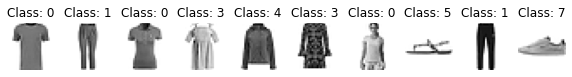

In [6]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    # [32, 1, 28, 28]의 데이터를 사람의 눈으로 확인할 수 있도록 [Width, Height, Channel]의 형태로 변환
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 6. AutoEncoder (AE) 모델 설계하기 '''
class AE(nn.Module): # Pytorch 모듈 내에 딥러닝 모델 관련 기본 함수를 포함하고 있는 nn.Module 클래스를 상속받는 Net 클래스를 정의
    def __init__(self): # AE 클래스의 인스턴스를 생성했을 때 지니게 되는 성질을 정의해주는 Method
        super(AE, self).__init__() # nn.Module 내에 있는 메서드를 상속받아 이용
        
        # Encoder에 대한 정의, 기존에는 def __inin__(self)를 이용해 모델을 설계하는 데 필요한 요소를 사전에 정의한 후 forward() 부분에서 호출해 사용
        self.encoder = nn.Sequential(   # nn.Sequential()을 이용해 인코더 단위를 한 번에 정의
            nn.Linear(28 * 28, 512), # FashionMNIST 데이터는 28 * 28 크기의 이미지 데이터이므로, 해당 이미지 데이터를 입력 받을 수 있도록 노드 수 설정, 두 번째 레이어의 Input 노드 수만큼 Output 설정
            nn.ReLU(), # 첫 번째의 레이어의 Output에 ReLU() 비선형 함수를 적용
            nn.Linear(512, 256), # 위와 동일
            nn.ReLU(), # 위와 동일
            nn.Linear(256, 32),) # 두 번째 레이어의 Output과 동일하게 Input 노드 수를 설정하고, Latent Variable Vecotr의 크기를 32로 설정
        
        self.decoder = nn.Sequential( # AutoEncoder의 디코더 정의, 인코더와 마찬가지로 nn.Sequential()을 이용해 한 번에 정의
            nn.Linear(32, 256), # 인코더로 생성한 Latent Variable Vector를 Input으로 이용하기 위해 32차원의 입력을 받음
            nn.ReLU(), # 위와 동일
            nn.Linear(256, 512), # 위와 동일
            nn.ReLU(), # 위와 동일
            nn.Linear(512, 28 * 28),) # Output의 노드 수는 원래 이미지 데이터와 Loss를 계산하기 때문에 기존 이미지 데이터의 크기로 노드 수 설정

    def forward(self, x): # nn.Sequential()을 이용해 정의한 AutoEncoder의 인코더와 디코더에 대해 Forward Propagation 정의 = 설계한 AutoEncoder의 인코더와 디코더에 데이터를 입력했을 때 Output을 계산하기까지의 과정 나열
        encoded = self.encoder(x) # 이미지 데이터를 사전에 정의한 인코더의 Input으로 이용해 Latent Variable Vecotr를 생성
        decoded = self.decoder(encoded) # Latent Variable Vector 값이 저장된 Encoded를 디코더의 Input으로 이용
        return encoded, decoded # 최종 계산된 두 결과값 반환

In [8]:
''' 7. Optimizer, Objective Function 설정하기 '''

model = AE().to(DEVICE) # 정의한 AE 모델을 기존에 선정한 DEVICE에 할당
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # Back Propagation을 통해 파라미터를 업데이트할 때 이용하는 Optimizer를 정의
criterion = nn.MSELoss() # AE 모델의 Output값과 계산될 Label 값은 이미지 데이터 그 자체이므로, AE 모델의 Output값은 Input으로 이용된 이미지 데이터와 복원된 이미지 데이터 값간의 MSE를 이용해 계산 

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [9]:
''' 8. AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train() # 기존에 정의한 AE 모델을 학습 상태로 지정
    # 기존에 정의한 train_loader에는 학습용 이미지 데이터와 레이블 데이터가 Batch 단위로 묶여 저장되어 있음
    for batch_idx, (image, _) in enumerate(train_loader): # 레이블 데이터를 활용해 학습하는 것이 아니라 입력 데이터를 타깃으로 학습하기 때문에 레이블 데이터를 이용할 필요가 없음
        image = image.view(-1, 28 * 28).to(DEVICE) # 기존에 정의한 AutoEncoder의 Input은 28 * 28 크기의 1차원 레이어이므로 2차원 이미지 데이터를 1차원 데이터로 재구성해 할당
        target = image.view(-1, 28 * 28).to(DEVICE) # 위와 동일
        # 이미지 데이터를 장비에 할당할 때, 과거에 이용한 Mini-Batch 내에 있는 이미지 데이터를 바탕으로 계산된 Loss의 Gradient 값이 Optimizer에 할당돼 있으므로 Optimizer의 Gradient 초기화
        optimizer.zero_grad() 
        encoded, decoded = model(image) # 장비에 할당한 이미지 데이터를 AE 모델의 Input으로 이용해 Output을 계산
        loss = criterion(decoded, target) # 계산된 Output과 이미지 데이터를 기존에 정의한 MSE를 이용해 Loss 값 계산
        loss.backward() # Loss 값을 계산한 결과를 바탕으로 역전파를 통해 계산된 Gradient 값을 각 파라미터에 할당
        optimizer.step() # 각 파라미터별 할당된 Gradient 값을 이용해 파라미터 값을 업데이트

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [10]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval() # 학습 과정 속 또는 학습이 완료된 AE 모델을 학습 상태가 아닌 평가 상태로 지정
    test_loss = 0 # 기존에 정의한 'test_loader' 내의 데이터로 Loss 값을 꼐산하기 위해 'test_loss'를 0으로 임시 설정
    real_image = [] # 학습 과정 속 AutoEncoder에 이용되는 실제 이미지 데이터를 리스트에 저장하기 위해 빈 리스트 할당
    gen_image = [] #3 생성되는 이미지 데이터를 리스트에 저장하기 위해 빈 리스트 할당
    with torch.no_grad(): # 평가하는 단계에서 Gradient를 통해 파라미터 값이 업데이트 되는 현상을 방지하기 위해 Gradient 흐름 억제
        for image, _ in test_loader: # 'test_loader' 내의 데이터도 Mini-Batch 단위로 저장되어 있음
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image) # 장비에 할당한 이미지 데이터를 AutoEncoder 모델의 Input으로 이용해 Output을 계산
            
            test_loss += criterion(decoded, image).item() # AutoEncoder 모델을 통해 생성된 이미지와 실제 이미지간 MSE 값을 계산해 test_loss 업데이트
            real_image.append(image.to("cpu")) # 실제 이미지로 할당된 이미지를 리스트에 추가
            gen_image.append(decoded.to("cpu")) # 생성된 이미지도 리스트에 추가
            
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE) # 현재까지 계산된 test_loss 값을 Mini-Batch 개수만큼 나눠 평균 Loss값 계산

    return test_loss, real_image, gen_image # 계산된 test_loss 값과 이미지 리스트들을 반환

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.199967
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.028466
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.023529
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.020149
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.020709
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.020290
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.017839
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.020645
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.013423
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.016240

[EPOCH: 1], 	Test Loss: 0.0154


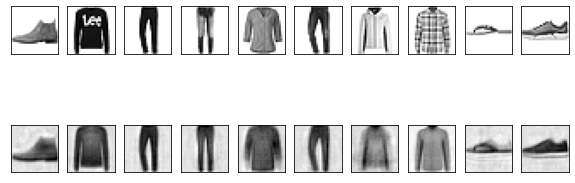

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.016476
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.013042
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.014179
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.017411
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.013189
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.015977
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.013476
Train Epoch: 2 [44800/60000 (75%)]	Train Loss: 0.011101
Train Epoch: 2 [51200/60000 (85%)]	Train Loss: 0.012193
Train Epoch: 2 [57600/60000 (96%)]	Train Loss: 0.011454

[EPOCH: 2], 	Test Loss: 0.0131


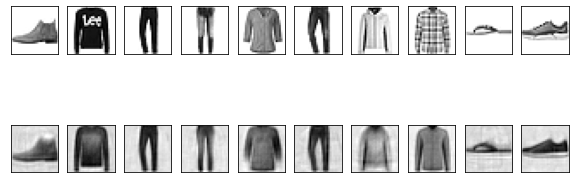

Train Epoch: 3 [0/60000 (0%)]	Train Loss: 0.013627
Train Epoch: 3 [6400/60000 (11%)]	Train Loss: 0.015151
Train Epoch: 3 [12800/60000 (21%)]	Train Loss: 0.013573
Train Epoch: 3 [19200/60000 (32%)]	Train Loss: 0.013617
Train Epoch: 3 [25600/60000 (43%)]	Train Loss: 0.010291
Train Epoch: 3 [32000/60000 (53%)]	Train Loss: 0.011084
Train Epoch: 3 [38400/60000 (64%)]	Train Loss: 0.014833
Train Epoch: 3 [44800/60000 (75%)]	Train Loss: 0.012199
Train Epoch: 3 [51200/60000 (85%)]	Train Loss: 0.012670
Train Epoch: 3 [57600/60000 (96%)]	Train Loss: 0.011879

[EPOCH: 3], 	Test Loss: 0.0121


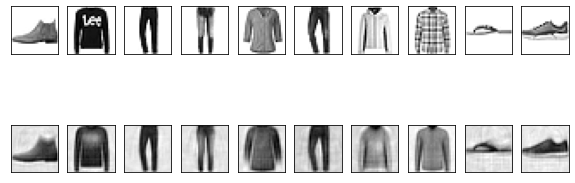

Train Epoch: 4 [0/60000 (0%)]	Train Loss: 0.016848
Train Epoch: 4 [6400/60000 (11%)]	Train Loss: 0.009595
Train Epoch: 4 [12800/60000 (21%)]	Train Loss: 0.012436
Train Epoch: 4 [19200/60000 (32%)]	Train Loss: 0.009833
Train Epoch: 4 [25600/60000 (43%)]	Train Loss: 0.013867
Train Epoch: 4 [32000/60000 (53%)]	Train Loss: 0.010725
Train Epoch: 4 [38400/60000 (64%)]	Train Loss: 0.013964
Train Epoch: 4 [44800/60000 (75%)]	Train Loss: 0.011803
Train Epoch: 4 [51200/60000 (85%)]	Train Loss: 0.009945
Train Epoch: 4 [57600/60000 (96%)]	Train Loss: 0.009773

[EPOCH: 4], 	Test Loss: 0.0114


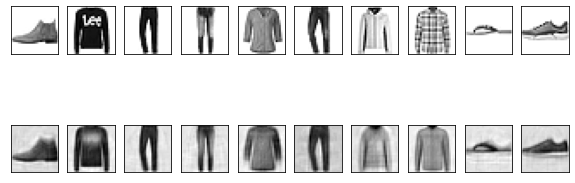

Train Epoch: 5 [0/60000 (0%)]	Train Loss: 0.012115
Train Epoch: 5 [6400/60000 (11%)]	Train Loss: 0.012714
Train Epoch: 5 [12800/60000 (21%)]	Train Loss: 0.009357
Train Epoch: 5 [19200/60000 (32%)]	Train Loss: 0.012070
Train Epoch: 5 [25600/60000 (43%)]	Train Loss: 0.011351
Train Epoch: 5 [32000/60000 (53%)]	Train Loss: 0.011032
Train Epoch: 5 [38400/60000 (64%)]	Train Loss: 0.010375
Train Epoch: 5 [44800/60000 (75%)]	Train Loss: 0.009009
Train Epoch: 5 [51200/60000 (85%)]	Train Loss: 0.008088
Train Epoch: 5 [57600/60000 (96%)]	Train Loss: 0.013284

[EPOCH: 5], 	Test Loss: 0.0109


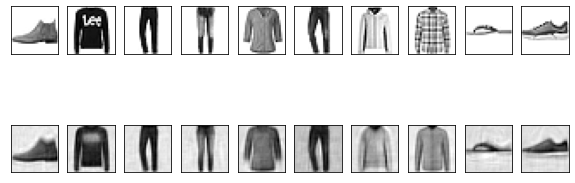

Train Epoch: 6 [0/60000 (0%)]	Train Loss: 0.010534
Train Epoch: 6 [6400/60000 (11%)]	Train Loss: 0.009436
Train Epoch: 6 [12800/60000 (21%)]	Train Loss: 0.010956
Train Epoch: 6 [19200/60000 (32%)]	Train Loss: 0.010008
Train Epoch: 6 [25600/60000 (43%)]	Train Loss: 0.010211
Train Epoch: 6 [32000/60000 (53%)]	Train Loss: 0.010813
Train Epoch: 6 [38400/60000 (64%)]	Train Loss: 0.010973
Train Epoch: 6 [44800/60000 (75%)]	Train Loss: 0.010286
Train Epoch: 6 [51200/60000 (85%)]	Train Loss: 0.010872
Train Epoch: 6 [57600/60000 (96%)]	Train Loss: 0.010944

[EPOCH: 6], 	Test Loss: 0.0106


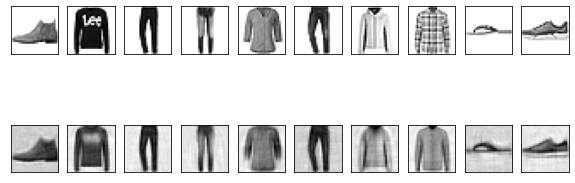

Train Epoch: 7 [0/60000 (0%)]	Train Loss: 0.009539
Train Epoch: 7 [6400/60000 (11%)]	Train Loss: 0.011102
Train Epoch: 7 [12800/60000 (21%)]	Train Loss: 0.011140
Train Epoch: 7 [19200/60000 (32%)]	Train Loss: 0.011295
Train Epoch: 7 [25600/60000 (43%)]	Train Loss: 0.009333
Train Epoch: 7 [32000/60000 (53%)]	Train Loss: 0.009730
Train Epoch: 7 [38400/60000 (64%)]	Train Loss: 0.009725
Train Epoch: 7 [44800/60000 (75%)]	Train Loss: 0.011936
Train Epoch: 7 [51200/60000 (85%)]	Train Loss: 0.010641
Train Epoch: 7 [57600/60000 (96%)]	Train Loss: 0.010314

[EPOCH: 7], 	Test Loss: 0.0104


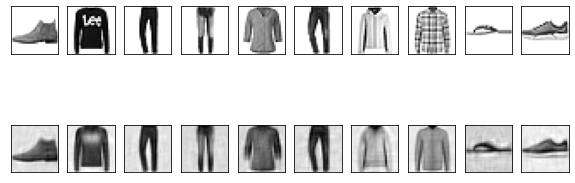

Train Epoch: 8 [0/60000 (0%)]	Train Loss: 0.008284
Train Epoch: 8 [6400/60000 (11%)]	Train Loss: 0.009126
Train Epoch: 8 [12800/60000 (21%)]	Train Loss: 0.009441
Train Epoch: 8 [19200/60000 (32%)]	Train Loss: 0.009821
Train Epoch: 8 [25600/60000 (43%)]	Train Loss: 0.011208
Train Epoch: 8 [32000/60000 (53%)]	Train Loss: 0.008173
Train Epoch: 8 [38400/60000 (64%)]	Train Loss: 0.008973
Train Epoch: 8 [44800/60000 (75%)]	Train Loss: 0.010798
Train Epoch: 8 [51200/60000 (85%)]	Train Loss: 0.008779
Train Epoch: 8 [57600/60000 (96%)]	Train Loss: 0.011521

[EPOCH: 8], 	Test Loss: 0.0101


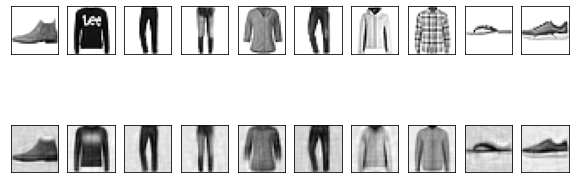

Train Epoch: 9 [0/60000 (0%)]	Train Loss: 0.009569
Train Epoch: 9 [6400/60000 (11%)]	Train Loss: 0.011022
Train Epoch: 9 [12800/60000 (21%)]	Train Loss: 0.010345
Train Epoch: 9 [19200/60000 (32%)]	Train Loss: 0.010218
Train Epoch: 9 [25600/60000 (43%)]	Train Loss: 0.009355
Train Epoch: 9 [32000/60000 (53%)]	Train Loss: 0.009866
Train Epoch: 9 [38400/60000 (64%)]	Train Loss: 0.010422
Train Epoch: 9 [44800/60000 (75%)]	Train Loss: 0.008161
Train Epoch: 9 [51200/60000 (85%)]	Train Loss: 0.008866
Train Epoch: 9 [57600/60000 (96%)]	Train Loss: 0.011027

[EPOCH: 9], 	Test Loss: 0.0100


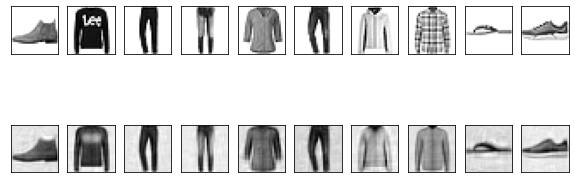

Train Epoch: 10 [0/60000 (0%)]	Train Loss: 0.009250
Train Epoch: 10 [6400/60000 (11%)]	Train Loss: 0.007834
Train Epoch: 10 [12800/60000 (21%)]	Train Loss: 0.007389
Train Epoch: 10 [19200/60000 (32%)]	Train Loss: 0.008445
Train Epoch: 10 [25600/60000 (43%)]	Train Loss: 0.007778
Train Epoch: 10 [32000/60000 (53%)]	Train Loss: 0.011322
Train Epoch: 10 [38400/60000 (64%)]	Train Loss: 0.010376
Train Epoch: 10 [44800/60000 (75%)]	Train Loss: 0.010032
Train Epoch: 10 [51200/60000 (85%)]	Train Loss: 0.008770
Train Epoch: 10 [57600/60000 (96%)]	Train Loss: 0.009122

[EPOCH: 10], 	Test Loss: 0.0097


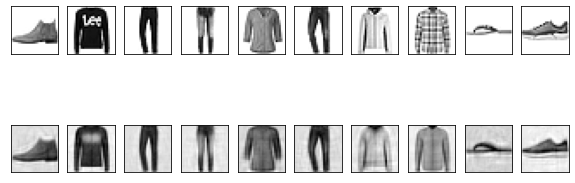

In [11]:
''' 10. AutoEncoder 학습 실행하며 Test set의 Reconstruction Error 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200) 
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(epoch, test_loss))
    # 2개의 for 문을 이용해 실제 이미지와 생성된 이미지를 비교해 학습의 진행도를 확인할 수 있음
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()